### NLP Transformer

In [2]:
!pip install --quiet 'pytorch-lightning==1.6.2'
!pip --quiet install transformers
!pip install --quiet datasets
!pip install --quiet seqeval
!pip install --quiet bidict


In [3]:
# import stuff
from pathlib import Path
from typing import Any, Tuple
from typing import Dict, Iterator, List, Union, Optional
import os


from datasets import load_metric

import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

import torch.optim as optim
import torch.nn as nn


from transformers import BertTokenizerFast, BertModel
from seqeval.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score


import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
import bisect
import random
import json
import bidict


import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


import pytorch_lightning as pl

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import loggers
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from pytorch_lightning import LightningDataModule
from pytorch_lightning.core import datamodule
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint


from argparse import ArgumentParser

seed_everything(42, workers=True)


import random


import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
print(os.getcwd())

Global seed set to 42


/content


In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
  print(torch.cuda.device_count())

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
fr = '/content/drive/MyDrive/data_hw2/FR'
en = '/content/drive/MyDrive/data_hw2/EN'
es = '/content/drive/MyDrive/data_hw2/ES'

### Data Module

In [8]:
class implementDataset(Dataset):

  def __init__(self, df):
      self.df = df

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    return self.df.loc[idx]

In [9]:
NUM_WORKERS = 4
class MyDataModule(LightningDataModule):

    def __init__(self, data_dir, batch_size):
      
        super().__init__()

        self.train_dir = data_dir + '/train.json'
        self.val_dir = data_dir + '/dev.json'
        self.batch_size = batch_size

    def prepare_data(self):
        return 

    def setup(self, stage=None):
        
        self.train = pd.read_json(self.train_dir, orient = 'index').dropna(axis = 0).reset_index(drop = True)
        self.val = pd.read_json(self.val_dir, orient = 'index').dropna(axis = 0).reset_index(drop = True)

        self.train = implementDataset(self.train)
        self.val = implementDataset(self.val)
        return 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn)

    def predict_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn)


In [10]:
class MyDataModule2(LightningDataModule):

    def __init__(self, data_dir, batch_size):
      
        super().__init__()

        self.train_dir = data_dir + '/train.json'
        self.val_dir = data_dir + '/dev.json'
        self.batch_size = batch_size

    def prepare_data(self):
        return 

    def setup(self, stage=None):
        
        self.train = pd.read_json(self.train_dir, orient = 'index').dropna(axis = 0).reset_index(drop = True)
        self.val = pd.read_json(self.val_dir, orient = 'index').dropna(axis = 0).reset_index(drop = True)

        self.train = implementDataset(self.train)
        self.val = implementDataset(self.val)
        return 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn2)

    def test_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn2)

    def predict_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers = NUM_WORKERS, collate_fn=collate_fn2)

In [11]:
df_train = pd.read_json('/content/drive/MyDrive/data_hw2/EN/train.json', orient = 'index').reset_index(drop = True)
len(df_train)
df_train.head()

,dependency_heads,dependency_relations,lemmas,pos_tags,predicates,roles,words
0,"[3, 3, 0, 8, 7, 7, 8, 3, 10, 8, 13, 13, 10, 3]","[nsubj, advmod, root, mark, det, amod, nsubj, ...","[member, also, ask, whether, all, social, grou...","[NOUN, ADV, VERB, SCONJ, DET, ADJ, NOUN, VERB,...","[_, _, ASK_REQUEST, _, _, _, _, BENEFIT_EXPLOI...","{'2': ['agent', '_', '_', 'theme', '_', '_', '...","[Members, also, asked, whether, all, social, g..."
1,"[4, 1, 4, 0, 9, 8, 8, 9, 4, 11, 9, 13, 11, 13,...","[advmod, punct, nsubj, root, mark, det, compou...","[finally, ,, member, ask, whether, the, Trinid...","[ADV, PUNCT, NOUN, VERB, SCONJ, DET, PROPN, NO...","[_, _, _, ASK_REQUEST, _, _, _, _, PLAN_SCHEDU...","{'3': ['_', '_', 'agent', '_', 'theme', '_', '...","[Finally, ,, members, asked, whether, the, Tri..."
2,"[3, 3, 7, 3, 6, 7, 0, 11, 10, 11, 7, 11, 12, 1...","[case, det, obl, punct, det, nsubj, root, mark...","[in, this, regard, ,, the, committee, recommen...","[ADP, DET, NOUN, PUNCT, DET, PROPN, VERB, SCON...","[_, _, _, _, _, _, PROPOSE, _, _, _, TAKE-INTO...","{'6': ['_', '_', '_', '_', '_', 'agent', '_', ...","[In, this, regard, ,, the, Committee, recommen..."
3,"[2, 3, 0, 8, 7, 7, 8, 3, 11, 11, 8, 13, 11, 13...","[det, nsubj, root, mark, det, compound, nsubj,...","[the, committee, recommend, that, the, State, ...","[DET, PROPN, VERB, SCONJ, DET, PROPN, NOUN, VE...","[_, _, PROPOSE, _, _, _, _, SHOW, _, _, _, _, ...","{'2': ['_', 'agent', '_', 'topic', '_', '_', '...","[The, Committee, recommends, that, the, State,..."
4,"[0, 1, 1, 5, 3, 7, 3, 9, 3, 13, 13, 13, 3, 16,...","[root, punct, obj, punct, conj, punct, conj, p...","[abstain, :, Argentina, ,, Bahamas, ,, Barbado...","[VERB, PUNCT, PROPN, PUNCT, PROPN, PUNCT, PROP...","[ABSTAIN_AVOID_REFRAIN, _, _, _, _, _, _, _, _...","{'0': ['_', '_', 'agent', '_', '_', '_', '_', ...","[Abstaining, :, Argentina, ,, Bahamas, ,, Barb..."


### Numerical mapping of labels, pos-tags etc...

In [ ]:
assert(1 == 2)  # prevents unintentional running of function

roles_set = set()
dr_set = set()
tags_set = set()

#### !!!!! dropna!!!!!!!
for row in df_train['roles'].dropna():
    for key, lst in row.items():
        for string in lst:
            roles_set.add(string)

for row in df_train['dependency_relations']:
    for item in row:
        dr_set.add(item)

for row in df_train['pos_tags']:
    for item in row:
        tags_set.add(item)



roles_ = {i: val for i, val in enumerate(roles_set)}
roles_dict = {v: k for k, v in roles_.items()}

dr_ = {i+1: val for i, val in enumerate(dr_set)}
dr = {v: k for k, v in dr_.items()}

tags_ = {i+1: val for i, val in enumerate(tags_set)}
tags = {v: k for k, v in tags_.items()}

In [ ]:
assert(1 == 2) # prevents unintentional running of function
a_file = open('/content/drive/MyDrive/nlp_pickled_dicts/roles_', "wb")
pickle.dump(roles_, a_file)
a_file.close()

a_file = open('/content/drive/MyDrive/nlp_pickled_dicts/roles_dict', "wb")
pickle.dump(roles_dict, a_file)
a_file.close()

a_file = open('/content/drive/MyDrive/nlp_pickled_dicts/dr_', "wb")
pickle.dump(dr_, a_file)
a_file.close()

a_file = open('/content/drive/MyDrive/nlp_pickled_dicts/dr', "wb")
pickle.dump(dr, a_file)
a_file.close()

a_file = open('/content/drive/MyDrive/nlp_pickled_dicts/tags_', "wb")
pickle.dump(tags_, a_file)
a_file.close()

a_file = open('/content/drive/MyDrive/nlp_pickled_dicts/tags', "wb")
pickle.dump(tags, a_file)
a_file.close()

In [12]:
with open('/content/drive/MyDrive/nlp_pickled_dicts/roles_', 'rb') as f:
    roles_ = pickle.load(f)

with open('/content/drive/MyDrive/nlp_pickled_dicts/roles_dict', 'rb') as f:
    roles_dict = pickle.load(f)

with open('/content/drive/MyDrive/nlp_pickled_dicts/dr_', 'rb') as f:
    dr_ = pickle.load(f)

with open('/content/drive/MyDrive/nlp_pickled_dicts/dr', 'rb') as f:
    dr = pickle.load(f)

with open('/content/drive/MyDrive/nlp_pickled_dicts/tags_', 'rb') as f:
    tags_ = pickle.load(f)

with open('/content/drive/MyDrive/nlp_pickled_dicts/tags', 'rb') as f:
   tags  = pickle.load(f)

In [13]:
dh_vals = set()
for lst in df_train.dependency_heads:
    for nums in lst:
        dh_vals.add(nums)

sorted_dh = sorted(dh_vals)

number_dict = {a: a for a in sorted_dh}


In [14]:
all_dicts = {}
inverse_dicts = {}

all_dicts['dependency_heads'] = number_dict
all_dicts['dependency_relations'] = dr
all_dicts['pos_tags'] = tags
all_dicts['roles'] = roles_dict

In [15]:
predicates = set()

for row in df_train['predicates']:
    for string in row:
            predicates.add(string)

_ 0.947 percent null class


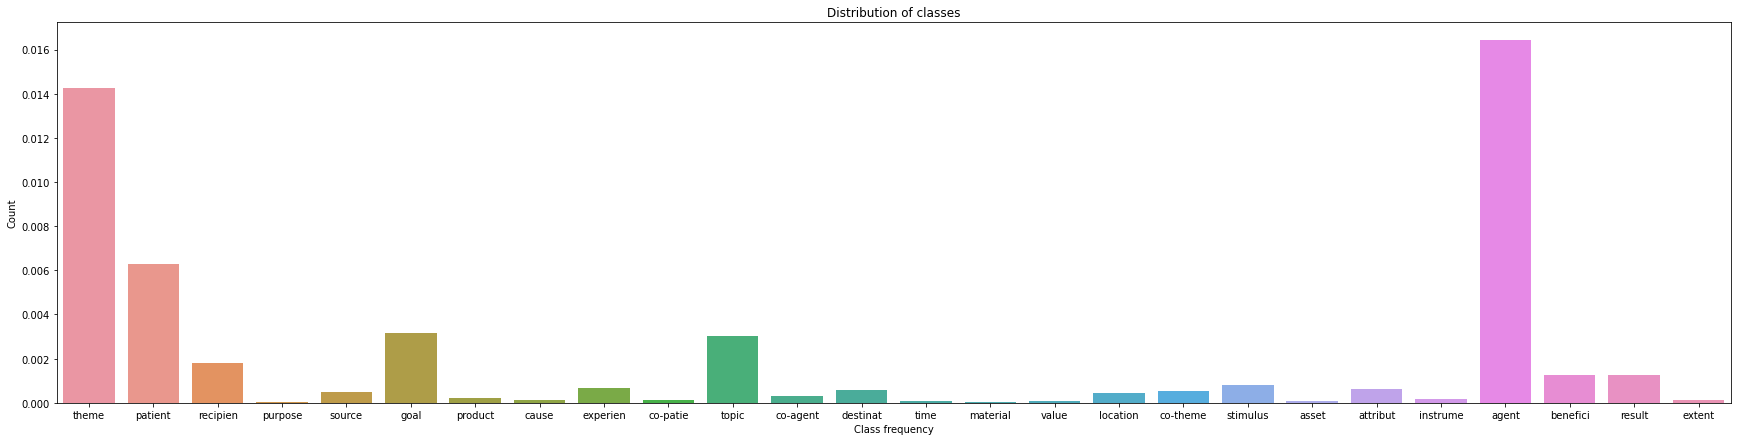

In [19]:
dist_classes = {key: 0 for key, value in roles_dict.items()}

sum = 0
for row in df_train['roles'].dropna():
    for key, lst in row.items():
        for string in lst:
            dist_classes[string] += 1
            sum += 1

dist_classes = {key: (value/sum) for key, value in dist_classes.items()}

keys =  list(dist_classes.keys())
vals = [float(dist_classes[k]) for k in keys]
print(keys[18], round(vals[18], 3), 'percent null class')
del keys[18]
del vals[18]
keys = [str(item[:8]) for item in keys]
fig, ax = plt.subplots(figsize=(30, 7))
ax = sns.barplot(x=keys, y=vals)
ax.set(xlabel='Class frequency', ylabel='Count', title = 'Distribution of classes')
plt.savefig('DistributionOfClasses.png')
plt.show()

# Collate function

In [16]:
def collate_helper_function(batch, string):
    
    map = all_dicts[string]
    
    x = [row[string] for row in batch]
    x = [[map.get(label) for label in sample] for sample in x]
    x = [torch.as_tensor(sample) for sample in x]

    x = pad_sequence(x, padding_value = 0, )

    x = torch.swapaxes(x, 0, 1) 
    #x = F.one_hot(x, num_classes=len(map))

    return x

In [17]:
# expands the batch and swaps axis so batch is first
def expand_word_ids(words, count_targets):
    batch_size = np.sum(count_targets)

    new_word_ids = []

    j = 0
    for i, count in enumerate(count_targets):
        for c in range(count):
            new_word_ids.append(words.word_ids(i))
            j += 1

    return new_word_ids

def expand_batch_tokens(tensor_dict, count_targets):

    batch_size = np.sum(count_targets)

    for key, tensor in tensor_dict.items():
        
        b, l = tensor.shape
        new_tensor = torch.Tensor(batch_size, l).type_as(tensor)

        j = 0
        for i, count in enumerate(count_targets):
            for c in range(count):
                new_tensor[j] = tensor[i]
                j += 1

        tensor_dict[key] = new_tensor

    return tensor_dict

def expand_batch_2D(tensor, count_targets):
    
    batch_size = np.sum(count_targets)
    
    b, l = tensor.shape

    new_tensor = torch.Tensor(batch_size, l).type_as(tensor)

    j = 0
    for i, count in enumerate(count_targets):
        for c in range(count):
            new_tensor[j] = tensor[i]
            j += 1

    return new_tensor

In [18]:
def allign(word_ids, x, value, pad):

    batch_size, length = x.shape
    new_length = len(word_ids[0])

    new_x = torch.Tensor(batch_size, new_length).type_as(x)

    for b in range(batch_size):

          
        j = -1
        for i in range(new_length):

            if(word_ids[b][i] == None):
                new_x[b][i] = value

            elif(word_ids[b][i] != word_ids[b][i-1]):
                j += 1
                new_x[b][i] = x[b][j]
            else:

                new_x[b][i] = value if pad else x[b][j]
             
    return new_x

In [19]:
def word_ids_equal_predicate(x, word_ids, keys):

    batch_size , sequence_length = x.shape
    
    for i in range(batch_size):
        for j in range(sequence_length):
            x[i][j] = (word_ids[i][j] == keys[i])

    return x
    

In [20]:
def collate_fn(batch):
    
    #
    binary_mask = pad_sequence([torch.ones(len(row['words'])) for row in batch], padding_value = 0)
    binary_mask = torch.swapaxes(binary_mask, 0, 1)

    # words and lemmas 
    words = [row['words'] for row in batch]
    words = tokenizer( words, return_tensors="pt", padding=True, is_split_into_words=True, add_special_tokens=True) ## So sequence length is equal to output length

    lemmas = [row['lemmas'] for row in batch]
    lemmas = tokenizer( lemmas, return_tensors="pt", padding=True, is_split_into_words=True, add_special_tokens=True)

   
    # roles and predicates : 

    targets, keys, count_keys = [], [], []

    roles = [row['roles'] for row in batch]

    for dict_ in roles:
        
        count_keys.append(len(dict_))
        for key, list_ in dict_.items():

            list_ = [roles_dict.get(label) for label in list_]
            list_ = torch.as_tensor(list_)
            targets.append(list_)
            keys.append(int(key))

    targets = pad_sequence(targets, padding_value = 0)
    targets = torch.swapaxes(targets, 0, 1)
    
    batch_size, sequence_length = targets.shape

    # creating binary vector indicating where keys are
    keys_one_hot = F.one_hot(torch.as_tensor(keys), sequence_length) # defined max sequence length
    
    dependency_heads = collate_helper_function(batch, 'dependency_heads')
    dependency_relations = collate_helper_function(batch, 'dependency_relations')
    pos_tags = collate_helper_function(batch, 'pos_tags')
    

    # Expand batch vertically 
    dependency_relations = expand_batch_2D(dependency_relations, count_keys)
    dependency_heads = expand_batch_2D(dependency_heads, count_keys)
    pos_tags = expand_batch_2D(pos_tags, count_keys)

    words = expand_batch_tokens(words, count_keys)
    lemmas = expand_batch_tokens(lemmas, count_keys)

    binary_mask = expand_batch_2D(binary_mask, count_keys)
    word_ids = expand_word_ids(words, count_keys)  ### used to allign

    # Expanding horizontally to match with subwords -- zero and -100 are pad tokens


    targets = allign(word_ids, targets, -100, True)
    binary_mask = allign(word_ids, binary_mask, 0, True)

    dependency_relations = allign(word_ids, dependency_relations, 0, False)
    dependency_heads = allign(word_ids, dependency_heads, 0, False)
    pos_tags = allign(word_ids, pos_tags, 0, False)
    keys_one_hot = allign(word_ids, keys_one_hot, 0, False)

    # indicate position of predicate
    words['token_type_ids'] = word_ids_equal_predicate(words['token_type_ids'], word_ids, keys)

    return {"words": words, 'dependency_relations': dependency_relations, 'dependency_heads': dependency_heads, 'lemmas': lemmas, 'pos_tags': pos_tags, 'keys': keys_one_hot, 'targets' : targets, 'count_keys' : count_keys, 'binary_mask': binary_mask, 'word_ids': word_ids}

In [21]:
def collate_fn2(batch):
    
    #
    binary_mask = pad_sequence([torch.ones(len(row['words'])) for row in batch], padding_value = 0)
    binary_mask = torch.swapaxes(binary_mask, 0, 1)

    # words and lemmas 
    words = [row['words'] for row in batch]
    words = tokenizer( words, return_tensors="pt", padding=True, is_split_into_words=True, add_special_tokens=True) ## So sequence length is equal to output length

    lemmas = [row['lemmas'] for row in batch]
    lemmas = tokenizer( lemmas, return_tensors="pt", padding=True, is_split_into_words=True, add_special_tokens=True)

   
    # roles and predicates : 

    targets, keys, count_keys = [], [], []

    roles = [row['roles'] for row in batch]

    for dict_ in roles:
        
        count_keys.append(len(dict_))
        for key, list_ in dict_.items():

            list_ = [roles_dict.get(label, 18) for label in list_]
            list_ = torch.as_tensor(list_)
            targets.append(list_)
            keys.append(int(key))

    targets = pad_sequence(targets, padding_value = 0)
    targets = torch.swapaxes(targets, 0, 1)
    
    batch_size, sequence_length = targets.shape

    # creating binary vector indicating where keys are
    keys_one_hot = F.one_hot(torch.as_tensor(keys), sequence_length) # defined max sequence length
    
    words = expand_batch_tokens(words, count_keys)
    lemmas = expand_batch_tokens(lemmas, count_keys)

    binary_mask = expand_batch_2D(binary_mask, count_keys)
    word_ids = expand_word_ids(words, count_keys)  ### used to allign

    # Expanding horizontally to match with subwords -- zero and -100 are pad tokens


    targets = allign(word_ids, targets, -100, True)
    binary_mask = allign(word_ids, binary_mask, 0, True)

    keys_one_hot = allign(word_ids, keys_one_hot, 0, False)

    # indicate position of predicate
    words['token_type_ids'] = word_ids_equal_predicate(words['token_type_ids'], word_ids, keys)

    return {"words": words, 'lemmas': lemmas, 'keys': keys_one_hot, 'targets' : targets, 'count_keys' : count_keys, 'binary_mask': binary_mask, 'word_ids': word_ids}

In [23]:
for index, row in df_train.iterrows():
    
    keys = row['roles'].keys()
    
    for key in keys:
        print(row.words[int(key)])
    if index > 2:
         break


asked
enjoyed
asked
intended
make
establish
facilitate
recommends
consider
undertaking
disseminate
concerning
recommends
show
preventing
committed
take
ensure
subjected


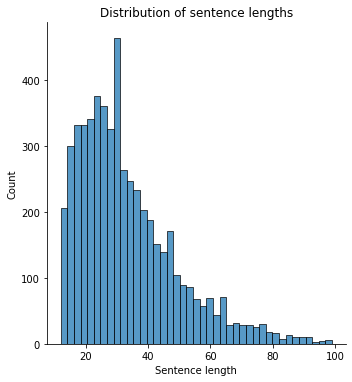

In [24]:
lengths = []
for row in df_train['words']:
    lengths.append(len(row))


ax = sns.displot(lengths)
ax.set(xlabel='Sentence length', ylabel='Count', title = 'Distribution of sentence lengths')
plt.show()

In [25]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input.view(-1, 27), target.view(-1), ignore_index=-100, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

### **Pytorch Lightning Module**

In [26]:
class Trans(pl.LightningModule):
    def __init__(self,
                  model_name = "bert-base-multilingual-cased",
                  num_labels = len(all_dicts['roles'])
                 ):

        super().__init__()

        # Chose model
        self.model = Sequential_model(model_name, num_labels)
        #self.model = Sequential_gru(model_name, num_labels)
        #self.model = Sequential_encoderHead(model_name, num_labels)

        self.lr = 2.29e-06
        self.weight_decay = 0
        #self.loss_fn= FocalLoss()
        self.class_weights = torch.ones(27).to(device)
        #self.class_weights[18] = 0.05

        self.last_labels = None
        self.last_preds = None

    def forward(self, b):
        return self.model(b)


    def training_step(self, batch, batch_idx):
        
        targets = batch.pop('targets')
        output = self(batch)
        loss = self.loss_fn(output, targets)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'output': output, 'targets': targets}

    def validation_step(self, batch, batch_idx):
        
        targets = batch.pop('targets')
        output = self(batch)
        loss = self.loss_fn(output, targets)

        self.log("Validation_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'output': output, 'targets': targets}

    def predict_step(self, batch, batch_idx):
        return self(batch)

    def test_step(self, batch, batch_idx):
        
        targets = batch.pop('targets')
        output = self(batch)
        
        return {'output': output, 'targets': targets}

    def testing_epoch_end(self, test_step_outputs):
        print('test_epoch_end')
        return test_step_outputs


    def validation_epoch_end(self, val_step_outputs):

        self.logg_fn(val_step_outputs)
        
        identification = self.evaluate_argument_identification(self.last_labels, self.last_preds)
        classification = self.evaluate_argument_classification(self.last_labels, self.last_preds)

        for key, value in identification.items():
            self.log('Validation_identification_' + key, round(value, 3))
        
        for key, value in classification.items():
            self.log('Validation_classification_' + key, round(value, 3))
    
    def training_epoch_end(self, train_step_outputs):

        self.logg_fn(train_step_outputs)

        identification = self.evaluate_argument_identification(self.last_labels, self.last_preds)
        classification = self.evaluate_argument_classification(self.last_labels, self.last_preds)

        for key, value in identification.items():
            self.log('Training_identification_' + key, round(value, 3))
        
        for key, value in classification.items():
            self.log('Training_classification_' + key, round(value, 3))

    def loss_fn(self, y_hat, targets):
        return F.cross_entropy(y_hat.view(-1, 27), targets.view(-1), ignore_index=-100, weight = self.class_weights)

    def logg_fn(self, x):
        predictions, labels = [], []

        for obj in x:

            output = obj['output']
            targets = obj['targets'].cpu().numpy()

            output_argmax = torch.argmax(output.detach().cpu(), dim = 2).numpy()

            
            true_predictions = [
                    [roles_[p] for (p, l) in zip(pred, gold_label) if l != -100]
                    for pred, gold_label in zip(output_argmax, targets)
                ]
            
            true_labels = [
                    [roles_[l] for (p, l) in zip(pred, gold_label) if l != -100]
                    for pred, gold_label in zip(output_argmax, targets)
                ]
            predictions += true_predictions
            labels += true_labels
        
        self.last_labels = labels
        self.last_preds = predictions
        
        return 
        return {"accuary": accuracy_score(labels, predictions),
                "precision": precision_score(labels, predictions),
                "recal": recall_score(labels, predictions),
                "f1": f1_score(labels, predictions)}

    def evaluate_argument_identification(self, labels, predictions, null_tag="_"):
        true_positives, false_positives, false_negatives = 0, 0, 0
        for i in range(len(labels)):
            gold = labels[i]
            pred = predictions[i]
            for r_g, r_p in zip(gold, pred):
                if r_g != null_tag and r_p != null_tag:
                    true_positives += 1
                elif r_g != null_tag and r_p == null_tag:
                    false_negatives += 1
                elif r_g == null_tag and r_p != null_tag:
                    false_positives += 1

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)
        return {
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
    
    def evaluate_argument_classification(self, labels, predictions, null_tag="_"):
        true_positives, false_positives, false_negatives = 0, 0, 0
        
        for i in range(len(labels)):
            gold = labels[i]
            pred = predictions[i]
            for r_g, r_p in zip(gold, pred):
                if r_g != null_tag and r_p != null_tag:
                    if r_g == r_p:
                        true_positives += 1
                    else:
                        false_positives += 1
                        false_negatives += 1
                elif r_g != null_tag and r_p == null_tag:
                    false_negatives += 1
                elif r_g == null_tag and r_p != null_tag:
                    false_positives += 1

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)
        return {
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    def configure_optimizers(self):
        
       
        model_params = {
            "params": self.model.parameters(),
            "lr": self.lr,
            "weight_decay": self.weight_decay,
        }

        optimizer = Adam(self.model.parameters(), lr=self.lr)

        scheduler = {
        'scheduler': ExponentialLR(optimizer = optimizer, gamma = 0.99),
        'interval': 'step',  # called after each training step
        'name' : 'penus'
        }

        return optimizer


## **Model architectures**

In [27]:
class Sequential_model(torch.nn.Module):

    def __init__(self, model_name = "bert-base-multilingual-cased", num_labels = len(all_dicts['roles'])):

        super().__init__()
        self.model_name = model_name
        self.num_labels = num_labels

        self.trans = BertModel.from_pretrained(self.model_name)
            
        self.classifier = torch.nn.Linear(
            self.trans.config.hidden_size, 
            num_labels, 
            bias=True
        )
        
    def forward(self, batch):
        
        x = batch['words']
        
        x = self.trans(**x)

        out, pooled = x.values()

        x = self.classifier(out)

        return x

In [28]:
class Sequential_encoderHead(torch.nn.Module):

    def __init__(self, model_name = "bert-base-multilingual-cased", num_labels = len(all_dicts['roles'])):

        super().__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.trans = BertModel.from_pretrained(self.model_name)

        l1, l2, l3 = len(all_dicts['dependency_heads']), len(all_dicts['pos_tags']), len(all_dicts['dependency_relations'])
        d1, d2, d3 = 30, 30, 30 # hyperparameters 
        d_key = 6

        self.embedding_heads = torch.nn.Embedding(l1 + 1, d1, padding_idx = 0) 
        self.embedding_tags = torch.nn.Embedding(l2 + 1, d2, padding_idx = 0) 
        self.embedding_relations = torch.nn.Embedding(l3 + 1, d3, padding_idx = 0)
        #self.embedding_keys = torch.nn.Embedding(2, d_key, padding_idx = 0)

        dim = d1 + d2 + self.trans.config.hidden_size 

        self.encoderHead = torch.nn.TransformerEncoderLayer(d_model = dim, nhead = 3, dropout=0.1, batch_first = True, )

        self.classifier = torch.nn.Linear(
            dim, 
            num_labels, 
            bias=True
        )

    def forward(self, batch):
        
        x = batch['words']

        tags = self.embedding_tags(batch['pos_tags'])
        rel = self.embedding_relations(batch['dependency_relations'])

        output, pooled = self.trans(**x).values()

        x_cat = torch.cat((output, rel, tags), 2)

        encoded_x = self.encoderHead(x_cat)


        x = self.classifier(encoded_x)

        return x

In [29]:
class Sequential_gru(torch.nn.Module):

    def __init__(self, model_name = "bert-base-multilingual-cased", num_labels = len(all_dicts['roles'])):

        super().__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        self.trans = BertModel.from_pretrained(self.model_name)

        l1, l2, l3 = len(all_dicts['dependency_heads']), len(all_dicts['pos_tags']), len(all_dicts['dependency_relations'])
        d1, d2, d3 = 30, 30, 30 # hyperparameters 

        self.projection_dim = 200

        self.embedding_heads = torch.nn.Embedding(l1 + 1, d1, padding_idx = 0) 
        self.embedding_tags = torch.nn.Embedding(l2 + 1, d2, padding_idx = 0) 
        self.embedding_relations = torch.nn.Embedding(l3 + 1, d3, padding_idx = 0)


        dim = d1 + d2 + self.trans.config.hidden_size 

        self.mlp = torch.nn.Linear(
            dim, 
            self.projection_dim, 
            bias=True
        )

        self.gru = torch.nn.GRU(input_size = self.projection_dim, hidden_size= self.projection_dim, num_layers = 1, batch_first = True, bidirectional = True)

        self.classifier = torch.nn.Linear(
            self.projection_dim * 2, 
            num_labels, 
            bias=True
        )

    def forward(self, batch):
        
        x = batch['words']

        tags = self.embedding_tags(batch['pos_tags'])
        rel = self.embedding_relations(batch['dependency_relations'])
   
        output, pooled = self.trans(**x).values()

        x_cat = torch.cat((output, rel, tags), 2)

        projected = self.mlp(x_cat)

        out, h  = self.gru(projected)

        x = self.classifier(out)

        return x

# **Training**

In [ ]:
logger = loggers.TensorBoardLogger('lightning_logs/', name="my_model")
from pytorch_lightning.loggers import CSVLogger
logger_cvs = CSVLogger('lightning_logs/', name="cvs_name")

checkpoint_callback = ModelCheckpoint(
    monitor='Validation_f1',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='new_model_2-{epoch:02d}-{Validation_f1:.2f}',
    save_top_k=1,
    mode = 'max'
    )

model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/base_model-epoch=19-Validation_f1=0.79.ckpt')


trainer = Trainer(accelerator="auto", max_epochs = 20, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback])
dev = Trainer(accelerator="auto", max_epochs = 1, fast_dev_run=True, )

#model = Trans()
module = MyDataModule(en, 16)

In [ ]:
trainer.fit(model, module)

In [ ]:
output = trainer.validate(model,module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.8209999799728394
Validation_classification_false_negatives                  903.0
Validation_classification_false_positives                  887.0
   Validation_classification_precision              0.8220000267028809
    Validation_classification_recall                0.8199999928474426
Validation_classification_true_positives                  4110.0
      Validation_identification_f1                  0.9010000228881836
Validation_identification_false_negatives                  503.0
Validation_identification_false_positives                  487.0
   Validation_identification_precision               0.902999997138977
    Valida

In [ ]:
from google.colab import files
files.download('/content/lightning_logs/cvs_name/version_1/metrics.csv')

## Saving and loading the transformer weights

In [ ]:
trainer.fit(model, module)
output = trainer.validate(model,module)
PATH = '/content/drive/MyDrive/nlp_models_weights/base_state_dict.pt'
torch.save(model.model.state_dict(), PATH)

In [ ]:
PATH = '/content/drive/MyDrive/nlp_models_weights/new_state_dict_model.pt'

#model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/model_simple-epoch=24-Validation_f1=0.87.ckpt')

#torch.save(model.model.state_dict(), PATH)


#model = Sequential_model()
#model.load_state_dict(torch.load(PATH))
#model.eval()



In [ ]:
save_classifier_path = '/content/drive/MyDrive/nlp_classifier_weight/20_classifier_weight.pt'
save_bert_path = '/content/drive/MyDrive/nlp_model_bert'

#torch.save(model.model.classifier.state_dict(), save_classifier_path)
#model.model.trans.save_pretrained(save_bert_path)

In [ ]:
class LoadModel(torch.nn.Module):

    def __init__(self, model_path = None, classifier_state_dict = None ,  num_labels = 27):

        super().__init__()

        self.num_labels = num_labels

        self.trans = BertModel.from_pretrained(model_path)
            
        self.classifier = torch.nn.Linear(
            self.trans.config.hidden_size, 
            num_labels, 
            bias=True
        )
        self.classifier.load_state_dict(torch.load(classifier_state_dict))

        
    def forward(self, batch):
        
        x = batch['words']
        
        x = self.trans(**x)

        out, pooled = x.values()

        x = self.classifier(out)

        return x

In [ ]:
loaded_model = LoadModel(save_bert_path, save_classifier_path, 27)

In [ ]:
model_2 = Trans()
model_2.model = loaded_model
output = trainer.validate(model_2,module)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.8209999799728394
Validation_classification_false_negatives                  903.0
Validation_classification_false_positives                  887.0
   Validation_classification_precision              0.8220000267028809
    Validation_classification_recall                0.8199999928474426
Validation_classification_true_positives                  4110.0
      Validation_identification_f1                  0.9010000228881836
Validation_identification_false_negatives                  503.0
Validation_identification_false_positives                  487.0
   Validation_identification_precision               0.902999997138977
    Valida

Language models - saving and loading

In [ ]:
french = MyDataModule2(fr, 16)
spanish = MyDataModule2(es, 16)

PATH = '/content/drive/MyDrive/nlp_models_weights/spanish_model.pt'

model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/spanish_model_2-epoch=14-Validation_f1=0.54.ckpt')
trainer.validate(model, spanish)
torch.save(model.model.state_dict(), PATH)




PATH = '/content/drive/MyDrive/nlp_models_weights/french_model.pt'

model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/french_model_2-epoch=14-Validation_f1=0.66.ckpt')
trainer.validate(model,french)

torch.save(model.model.state_dict(), PATH)

## **Spanish and French**

In [ ]:

french = MyDataModule2(fr, 16)
spanish = MyDataModule2(es, 16)

checkpoint_callback_es = ModelCheckpoint(
    monitor='Validation_f1',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='spanish_model-{epoch:02d}-{Validation_f1:.2f}',
    save_top_k=1,
    mode = 'max'
    )
checkpoint_callback_es_2 = ModelCheckpoint(
    monitor='Validation_f1',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='spanish_model_2-{epoch:02d}-{Validation_f1:.2f}',
    save_top_k=1,
    mode = 'max'
    )
checkpoint_callback_fr = ModelCheckpoint(
    monitor='Validation_f1',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='french_model-{epoch:02d}-{Validation_f1:.2f}',
    save_top_k=1,
    mode = 'max'
    )
checkpoint_callback_fr_2 = ModelCheckpoint(
    monitor='Validation_f1',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='french_model_2-{epoch:02d}-{Validation_f1:.2f}',
    save_top_k=1,
    mode = 'max'
    )

In [ ]:
model = Trans()
trainer = Trainer(accelerator="auto", max_epochs = 15, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback_fr])
trainer.fit(model,french)

In [ ]:
model = Trans()
trainer = Trainer(accelerator="auto", max_epochs = 15, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback_es])
trainer.fit(model,spanish)

In [ ]:
model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/base_model-epoch=19-Validation_f1=0.79.ckpt')
trainer = Trainer(accelerator="auto", max_epochs = 15, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback_fr_2])
trainer.fit(model,french)


In [ ]:
model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/base_model-epoch=19-Validation_f1=0.79.ckpt')
trainer = Trainer(accelerator="auto", max_epochs = 15, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback_es_2])
trainer.fit(model,spanish)


In [ ]:
model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/french_model-epoch=14-Validation_f1=0.44.ckpt')
output = trainer.validate(model,french)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.42899999022483826
Validation_classification_false_negatives                 3107.0
Validation_classification_false_positives                 1949.0
   Validation_classification_precision              0.49300000071525574
    Validation_classification_recall                0.3790000081062317
Validation_classification_true_positives                  1896.0
      Validation_identification_f1                  0.7289999723434448
Validation_identification_false_negatives                 1776.0
Validation_identification_false_positives                  618.0
   Validation_identification_precision              0.8389999866485596
    Vali

In [ ]:
model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/french_model_2-epoch=14-Validation_f1=0.66.ckpt')
output = trainer.validate(model,french)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.6620000004768372
Validation_classification_false_negatives                 1794.0
Validation_classification_false_positives                 1480.0
   Validation_classification_precision              0.6840000152587891
    Validation_classification_recall                 0.640999972820282
Validation_classification_true_positives                  3209.0
      Validation_identification_f1                  0.8489999771118164
Validation_identification_false_negatives                  891.0
Validation_identification_false_positives                  577.0
   Validation_identification_precision              0.8769999742507935
    Valida

In [ ]:
model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/spanish_model-epoch=14-Validation_f1=0.46.ckpt')
output = trainer.validate(model,spanish)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.4729999899864197
Validation_classification_false_negatives                 2742.0
Validation_classification_false_positives                 1733.0
   Validation_classification_precision              0.5370000004768372
    Validation_classification_recall                0.4230000078678131
Validation_classification_true_positives                  2008.0
      Validation_identification_f1                  0.7170000076293945
Validation_identification_false_negatives                 1705.0
Validation_identification_false_positives                  696.0
   Validation_identification_precision              0.8140000104904175
    Valida

In [ ]:
model = Trans().load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/nlp_checkpoints/spanish_model_2-epoch=14-Validation_f1=0.54.ckpt')
output = trainer.validate(model,spanish)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.5370000004768372
Validation_classification_false_negatives                 2365.0
Validation_classification_false_positives                 1740.0
   Validation_classification_precision               0.578000009059906
    Validation_classification_recall                0.5019999742507935
Validation_classification_true_positives                  2385.0
      Validation_identification_f1                  0.7789999842643738
Validation_identification_false_negatives                 1293.0
Validation_identification_false_positives                  668.0
   Validation_identification_precision              0.8379999995231628
    Valida

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
results = trainer.test(model, module)

## **Confustion matrix**

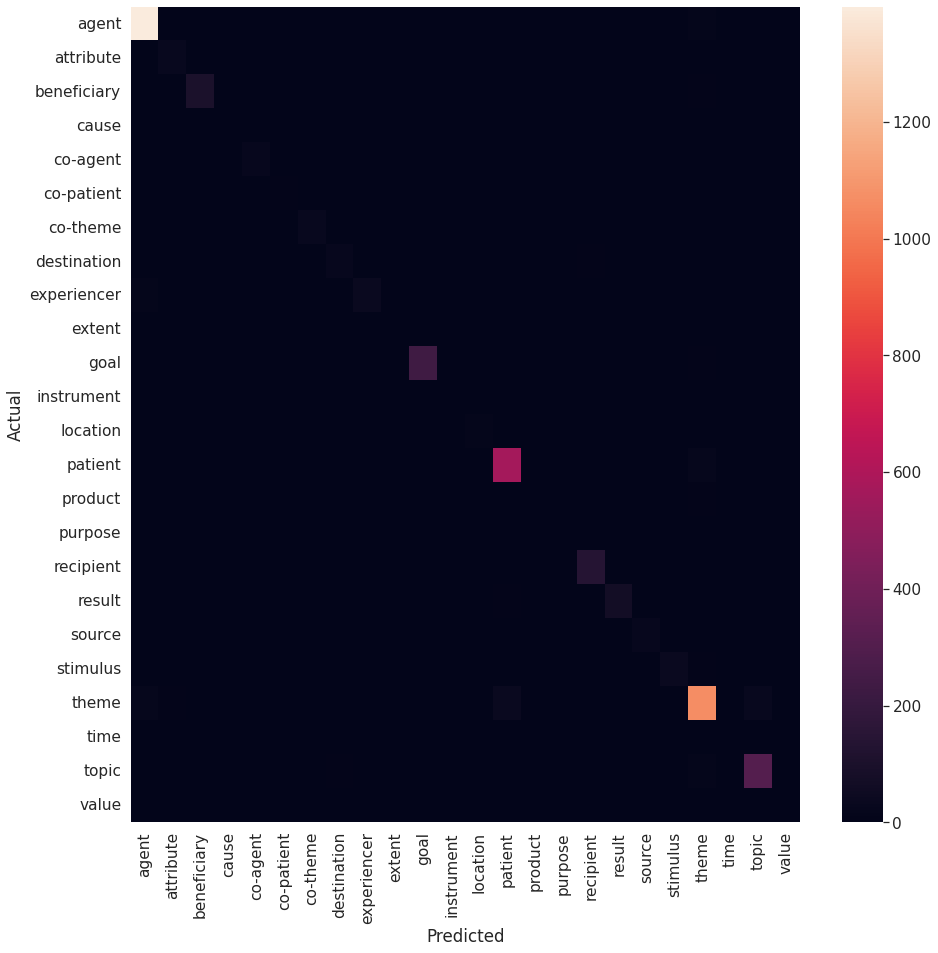

In [33]:
labels = [element for sublist in model.last_labels for element in sublist]
preds = [element for sublist in model.last_preds for element in sublist]

y_true = []
y_pred = []
null_label = '_'
for t, p in zip(labels, preds):
    if t != null_label and p != null_label:
        y_true.append(t)
        y_pred.append(p)

data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (15,15))
sns.set(font_scale=1.4)#for label size
sns.color_palette("cubehelix", as_cmap=True)
sns.heatmap(df_cm, annot=False, annot_kws={"size": 15})# font size
plt.savefig('dazed_and_confuzed_matrix.png')
plt.show()

In [ ]:
output = trainer.validate(model,module)

In [77]:
output

[{'Validation_classification_f1': 0.8209999799728394,
  'Validation_classification_false_negatives': 903.0,
  'Validation_classification_false_positives': 887.0,
  'Validation_classification_precision': 0.8220000267028809,
  'Validation_classification_recall': 0.8199999928474426,
  'Validation_classification_true_positives': 4110.0,
  'Validation_identification_f1': 0.9010000228881836,
  'Validation_identification_false_negatives': 503.0,
  'Validation_identification_false_positives': 487.0,
  'Validation_identification_precision': 0.902999997138977,
  'Validation_identification_recall': 0.8999999761581421,
  'Validation_identification_true_positives': 4510.0,
  'Validation_loss_epoch': 0.059255219995975494}]

In [57]:
new_dict = {}
for key in roles_dict.keys():
    new_dict[key] = (0,0)

for t, p in zip(labels, preds):
    x, y = new_dict[t]
    if t == p:
        new_dict[t] = (x + 1, y + 1)
    else:
        new_dict[t] = (x+1, y)

for key, item in new_dict.items():
    x, y = item
    new_dict[key] = (x, y, round(y/x, 2))

In [ ]:
sum_1, sum_2 = 0, 0
for key, item in new_dict.items():
    print(key, '&' , item[0], '&', item[1], '&', round(item[2] * 100), "\%")
    sum_1 += item[0]
    sum_2 += item[1]
sum_3 = sum_2/sum_1
print('Sum', '&' , sum_1, '&', sum_2, '&', round(sum_3 * 100), "\%")

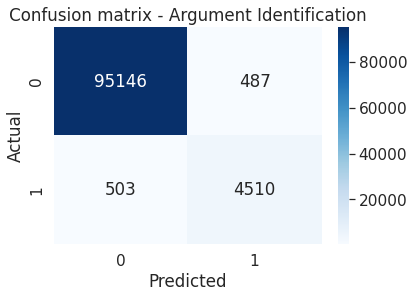

In [115]:
a =([new_dict['_'][1], 487],
    [503, 4510])

plt.title('Confusion matrix - Argument Identification')
sns.heatmap(a, annot=a, fmt='', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('i.png')
plt.show()

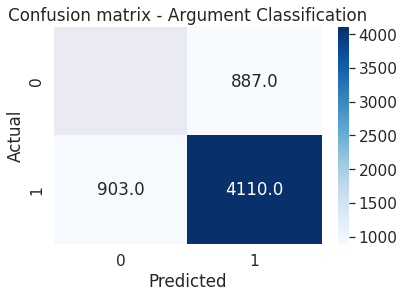

In [116]:
a =([np.nan, 887],
    [903, 4110])

plt.title('Confusion matrix - Argument Classification')
sns.heatmap(a, annot=a, fmt='', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('c.png')
plt.show()

## Predict and decode

In [ ]:
output = trainer.predict(model, module)[0]

In [ ]:
def decode_output(output, batch):


    output_argmax = torch.argmax(output.detach(), dim = 2).numpy()
    
    print(output_argmax[1])
    
    binary_mask = batch['binary_mask']  ### USE instead


    decoded = []
    for i in range(len(binary_mask)):
        list_ = []
        for j in range(len(binary_mask[0])):
            if (binary_mask[i][j] == True):
                pred = roles_[output_argmax[i][j]] # Correct??
                list_.append(pred)
        decoded.append(list_)
        print(list_)

    list_of_dicts = []

    i = 0 
    keys = batch['keys']
    for num in batch['count_keys']:

        dict_ = {}
        for j in range(num):
            dict_[keys[i]] = decoded[i]
        
            i += 1
        list_of_dicts.append(dict_)

    return list_of_dicts

decoded_output = decode_output(output,batch)

**Metrics cvs**

In [ ]:
metrics = pd.read_csv('/content/metrics_1.csv')
val_loss = metrics.Validation_loss_epoch.dropna().reset_index(drop = True)[:-1]
train_loss = metrics.train_loss_epoch.dropna().reset_index(drop = True)
v_f1 = metrics.Validation_f1.dropna().reset_index(drop = True)[:-1]
t_f1 = metrics.Training_f1.dropna().reset_index(drop = True)


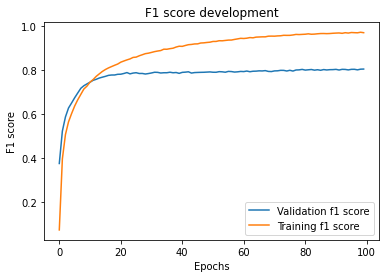

In [ ]:
fig, ax = plt.subplots()
ax.plot(v_f1, label = 'Validation f1 score')
ax.plot(t_f1, label = 'Training f1 score')
ax.legend()
ax.set_title('F1 score development',)
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 score')
plt.savefig('f1.png')
plt.show()

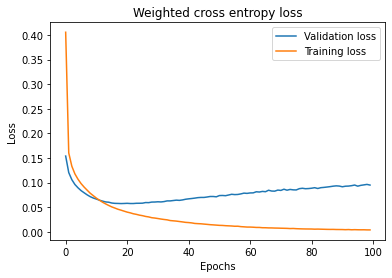

In [ ]:
fig, ax = plt.subplots()
ax.plot(val_loss, label = 'Validation loss')
ax.plot(train_loss, label = 'Training loss')
ax.legend()
ax.set_title('Weighted cross entropy loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.savefig('loss_.png')
plt.show()

## **Training with recurrent layers**

In [ ]:
logger = loggers.TensorBoardLogger('lightning_logs/', name="recurrent_model")
from pytorch_lightning.loggers import CSVLogger
logger_cvs = CSVLogger('lightning_logs/', name="cvs_recurrent")

checkpoint_callback = ModelCheckpoint(
    monitor='Validation_loss_epoch',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='Gru_bidir_5-{epoch:02d}-{Validation_f1:.2f}',
    save_top_k=1,
    mode = 'min'
    )

model = Trans().load_from_checkpoint(checkpoint_path = '/content/drive/MyDrive/nlp_checkpoints/Gru_bidir_5-epoch=03-Validation_f1=0.00.ckpt')

trainer = Trainer(accelerator="auto", max_epochs = 30, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback])
dev = Trainer(accelerator="auto", max_epochs = 1, fast_dev_run=True, )


module = MyDataModule(en, 16)

In [ ]:
dev.fit(model, module)

In [ ]:
trainer.fit(model, module)

In [ ]:
output = trainer.validate(model,module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.8100000023841858
Validation_classification_false_negatives                  919.0
Validation_classification_false_positives                  997.0
   Validation_classification_precision              0.8040000200271606
    Validation_classification_recall                0.8169999718666077
Validation_classification_true_positives                  4094.0
      Validation_identification_f1                  0.8989999890327454
Validation_identification_false_negatives                  470.0
Validation_identification_false_positives                  548.0
   Validation_identification_precision              0.8920000195503235
    Valida

In [ ]:
metrics = pd.read_csv('/content/lightning_logs/cvs_recurrent/version_5/metrics.csv')
val_loss = metrics.Validation_loss_epoch.dropna().reset_index(drop = True)[:-1]
train_loss = metrics.train_loss_epoch.dropna().reset_index(drop = True)
#v_f1 = metrics.Validation_f1.dropna().reset_index(drop = True)[:-1]
#t_f1 = metrics.Training_f1.dropna().reset_index(drop = True)

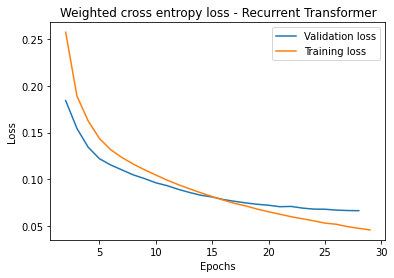

In [ ]:
fig, ax = plt.subplots()
ax.plot(val_loss[2:], label = 'Validation loss')
ax.plot(train_loss[2:], label = 'Training loss')
ax.legend()
ax.set_title('Weighted cross entropy loss - Recurrent Transformer')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.savefig('recurrent_loss.png')
plt.show()

## Training with additional attention encoder

In [ ]:
logger = loggers.TensorBoardLogger('lightning_logs/', name="attention_model")
from pytorch_lightning.loggers import CSVLogger
logger_cvs = CSVLogger('lightning_logs/', name="cvs_attention")

checkpoint_callback = ModelCheckpoint(
    monitor='Validation_loss_epoch',
    dirpath='/content/drive/MyDrive/nlp_checkpoints',
    filename='attention-{epoch:02d}-{Validation_loss_epoch:.2f}',
    save_top_k=1,
    mode = 'min'
    )

model = Trans().load_from_checkpoint(checkpoint_path = '/content/drive/MyDrive/nlp_checkpoints/attention-epoch=17-Validation_loss_epoch=0.06.ckpt')

trainer = Trainer(accelerator="auto", max_epochs = 30, auto_lr_find= True, gradient_clip_val=0.5, logger = [logger,logger_cvs], callbacks=[checkpoint_callback])
dev = Trainer(accelerator="auto", max_epochs = 1, fast_dev_run=True, )


module = MyDataModule(en, 16)

In [ ]:
trainer.fit(model,module)

In [ ]:
output = trainer.validate(model, module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Validate metric                           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validation_classification_f1                  0.8270000219345093
Validation_classification_false_negatives                  867.0
Validation_classification_false_positives                  870.0
   Validation_classification_precision              0.8270000219345093
    Validation_classification_recall                0.8270000219345093
Validation_classification_true_positives                  4146.0
      Validation_identification_f1                  0.9010000228881836
Validation_identification_false_negatives                  495.0
Validation_identification_false_positives                  498.0
   Validation_identification_precision              0.9010000228881836
    Valida

In [ ]:
metrics = pd.read_csv('/content/lightning_logs/cvs_attention/version_1/metrics.csv')
val_loss = metrics.Validation_loss_epoch.dropna().reset_index(drop = True)[:-1]
train_loss = metrics.train_loss_epoch.dropna().reset_index(drop = True)

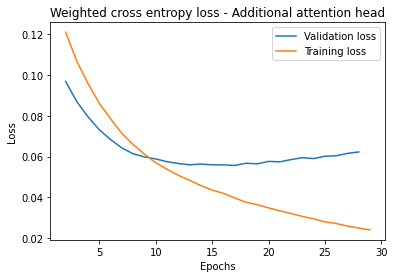

In [ ]:
fig, ax = plt.subplots()
ax.plot(val_loss[2:], label = 'Validation loss')
ax.plot(train_loss[2:], label = 'Training loss')
ax.legend()
ax.set_title('Weighted cross entropy loss - Additional attention head')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.savefig('attention_loss.png')
plt.show()